In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import numpy as np
import pandas as pd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data_dir = Path("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final.h5ad")
adata = sc.read(data_dir)
adata

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 83476 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'

In [3]:
adata.n_vars

62710

In [4]:
data_is_raw = True


In [5]:
!ls

 baseline_filtered.pkl
 boxplot_83968_samples_mean_9387.77.png
 job.sb
 scgpt_gene_biotypes.csv
 slurm-15039023.out
 slurm-15047666.out
 slurm-15397690.out
 slurm-15398051.out
 slurm-15398423.out
 tahoe_filter_count.py
 vevo_adamson_attn.ipynb
 vevo_adamson_gene_emb.ipynb
 vevo_adamson_mask.ipynb
 vevo_adamson_mask_null.py
 vevo_adamson_mask.py
'vevo_norman_gene_emb copy.ipynb'
 vevo_norman_gene_emb.ipynb
 vevo_norman_gene_mask.ipynb
 vevo_norman_mask.py
 vevo_tahoe_wilcoxon_filter_count.ipynb
 vevo_tahoe_wilcoxon_filter_protein_coding.ipynb
 vevo_tahoe_wilcoxon_hvg.ipynb
 wandb
 wilcoxon_filtered.pkl


In [6]:
# filter by protein coding gene
df = pd.read_csv("scgpt_gene_biotypes.csv")

In [7]:
df

,feature_id,feature_name,feature_length,feature_type
0,ENSG00000121410,A1BG,3999,protein_coding
1,ENSG00000268895,A1BG-AS1,3374,lncRNA
2,ENSG00000148584,A1CF,9603,protein_coding
3,ENSG00000175899,A2M,6318,protein_coding
4,ENSG00000245105,A2M-AS1,2948,lncRNA
...,...,...,...,...
60512,ENSG00000288719,RP4-669P10.21,4252,lncRNA
60513,ENSG00000288720,RP11-852E15.3,7007,lncRNA
60514,ENSG00000288721,RP5-973N23.5,7765,protein_coding
60515,ENSG00000288723,RP11-553N16.6,1015,lncRNA


In [9]:
protein_coding_genes = df[df["feature_type"] == "protein_coding"]["feature_name"].tolist()
len(protein_coding_genes)

19966

In [10]:
protein_coding_genes[:5]

['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']

In [12]:
adata.var.index

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'POLGARF', 'ENSG00000291308', 'LY6S', 'ENSG00000291310',
       'ENSG00000291312', 'ENSG00000291313', 'ENSG00000291314',
       'ENSG00000291315', 'ENSG00000291316', 'TMEM276'],
      dtype='object', name='gene_name', length=62710)

In [13]:
mask = adata.var.index.isin(protein_coding_genes)
adata = adata[:, mask].copy()

In [14]:
adata

AnnData object with n_obs × n_vars = 83476 × 19219
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'

In [15]:
drug_df = pd.read_csv("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final_targets.csv")
drug_target_map = dict(zip(drug_df["compound"], drug_df["targets"]))

perturb_conditions = list(drug_target_map.values())
condition_names_gene = perturb_conditions

drug_target_map["ctrl"] = "ctrl"

In [16]:
len(condition_names_gene)

34

In [17]:
condition_names_gene

['EIF4E',
 'GSK3B',
 'PIK3CA',
 'CYP19A1',
 'PRKDC',
 'MTOR',
 'ATM',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'ATR',
 'MAPK7',
 'PRKAA1',
 'PBK',
 'TOP1',
 'PSMB5',
 'RPS6KB1',
 'NR3C1',
 'PRKAA1',
 'KLF5',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'MTOR',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [18]:
# add_counter = 0
# for g in condition_names_gene:
#     if not adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'].values[0]:
#         adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'] = True
#         add_counter += 1

In [19]:
# print('Manually add conditions: {}, {}'.format(add_counter, add_counter/len(condition_names_gene)))

In [20]:
# adata = adata[:, adata.var["highly_variable"]].copy()


In [21]:
adata

AnnData object with n_obs × n_vars = 83476 × 19219
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'

In [22]:
adata.obs["gene_target"] = adata.obs["condition"].map(drug_target_map)

In [23]:
def sample_cells_per_label(adata, column, n=75, random_state=None):
    """
    Randomly sample `n` cells per unique label in `adata.obs[column]`.
    
    Parameters:
        adata (AnnData): The AnnData object.
        column (str): Column in `adata.obs` to sample from.
        n (int): Number of cells to sample per label.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        AnnData: A new AnnData object with the sampled cells.
    """
    sampled_indices = (
        adata.obs.groupby(column)
        .apply(lambda x: x.sample(n=min(n, len(x)), random_state=random_state))
        .index.get_level_values(1)
    )
    
    return adata[sampled_indices].copy()
# adata = sample_cells_per_label(adata, column="gene_target", n=75, random_state=42)
# adata

In [24]:
adata.obs["gene_target"]

BARCODE_SUB_LIB_ID
08_003_169-lib_1000    TOP1
08_028_044-lib_1000    TOP1
08_046_119-lib_1000    TOP1
08_050_191-lib_1000    TOP1
08_064_086-lib_1000    TOP1
                       ... 
96_133_088-lib_999     ctrl
96_144_143-lib_999     ctrl
96_146_192-lib_999     ctrl
96_172_041-lib_999     ctrl
96_173_021-lib_999     ctrl
Name: gene_target, Length: 83476, dtype: object

In [25]:
adata

AnnData object with n_obs × n_vars = 83476 × 19219
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage', 'gene_target'

In [26]:
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import pandas as pd

In [27]:
max_len = adata.shape[1] + 1
max_len

19220

In [28]:
adata.X[:5, :5].toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [29]:
sc.pp.log1p(adata)

# Baseline Wilcoxon

In [30]:
# Wilcoxon rank
sc.tl.rank_genes_groups(adata, 'gene_target', method='wilcoxon', key_added = "wilcoxon", n_genes=max_len-1, reference='ctrl')
adata.uns['wilcoxon']['names']

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is hi

rec.array([('RPL3', 'HNRNPA1', 'RPS19', 'NPM1', 'NPM1', 'MYH9', 'NRIP1', 'FTL', 'RPS3', 'RPL4', 'RPS19', 'RPS8', 'FTH1', 'EEF2', 'EEF1G', 'MT-ND4', 'RPS3', 'RPLP1', 'RPS4X', 'RPS2', 'RPS19', 'MT-ND2', 'CRIM1', 'RPL12', 'RPS3', 'EEF2', 'MT2A', 'HSP90AB1', 'FTL', 'FTL', 'SMAD3'),
           ('RACK1', 'PPP1R15A', 'MT-ATP8', 'HSP90AB1', 'RPS6', 'RPS2', 'PABPC1', 'MT-ND2', 'MT2A', 'ALDOA', 'RPS3', 'MT-ATP8', 'NPM1', 'MYH9', 'MT-ND4', 'RPS3', 'EEF2', 'RPS3', 'CRIM1', 'NPM1', 'RPS3', 'MT-ATP8', 'FAM107B', 'RPS19', 'RPS6', 'HSPD1', 'RPS19', 'NCL', 'RPS19', 'MT-ATP8', 'CRIM1'),
           ('EEF2', 'MT-ND6', 'RPS6', 'PLOD2', 'ACTG1', 'PLEC', 'TFPI', 'RPS3', 'RPS19', 'MYH9', 'RPL37A', 'RPS3', 'FTL', 'PLEC', 'MT-CO1', 'FTL', 'RPS19', 'RPS19', 'TRIO', 'FTL', 'MT2A', 'RPS3', 'SMAD3', 'RPS3', 'MT-ATP8', 'HSP90AB1', 'MT-ATP8', 'NPM1', 'RPS8', 'RPS3', 'FNDC3B'),
           ...,
           ('EFNA5', 'PDE4D', 'MT-ND1', 'MT-CO1', 'AADAC', 'NDRG1', 'IGFBP4', 'HSPA5', 'EFNA5', 'NDRG1', 'PDE4D', 'EGFR', 'EGR

In [31]:
adata.uns['wilcoxon']

{'params': {'groupby': 'gene_target',
  'reference': 'ctrl',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('RPL3', 'HNRNPA1', 'RPS19', 'NPM1', 'NPM1', 'MYH9', 'NRIP1', 'FTL', 'RPS3', 'RPL4', 'RPS19', 'RPS8', 'FTH1', 'EEF2', 'EEF1G', 'MT-ND4', 'RPS3', 'RPLP1', 'RPS4X', 'RPS2', 'RPS19', 'MT-ND2', 'CRIM1', 'RPL12', 'RPS3', 'EEF2', 'MT2A', 'HSP90AB1', 'FTL', 'FTL', 'SMAD3'),
            ('RACK1', 'PPP1R15A', 'MT-ATP8', 'HSP90AB1', 'RPS6', 'RPS2', 'PABPC1', 'MT-ND2', 'MT2A', 'ALDOA', 'RPS3', 'MT-ATP8', 'NPM1', 'MYH9', 'MT-ND4', 'RPS3', 'EEF2', 'RPS3', 'CRIM1', 'NPM1', 'RPS3', 'MT-ATP8', 'FAM107B', 'RPS19', 'RPS6', 'HSPD1', 'RPS19', 'NCL', 'RPS19', 'MT-ATP8', 'CRIM1'),
            ('EEF2', 'MT-ND6', 'RPS6', 'PLOD2', 'ACTG1', 'PLEC', 'TFPI', 'RPS3', 'RPS19', 'MYH9', 'RPL37A', 'RPS3', 'FTL', 'PLEC', 'MT-CO1', 'FTL', 'RPS19', 'RPS19', 'TRIO', 'FTL', 'MT2A', 'RPS3', 'SMAD3', 'RPS3', 'MT-ATP8', 'HSP90AB1', 'MT-ATP8', 'NP

In [32]:
import pickle

# Save to a pickle file
with open("wilcoxon_filtered.pkl", "wb") as f:
    pickle.dump(adata.uns["wilcoxon"], f)

In [33]:
adata.uns['wilcoxon']['names']

rec.array([('RPL3', 'HNRNPA1', 'RPS19', 'NPM1', 'NPM1', 'MYH9', 'NRIP1', 'FTL', 'RPS3', 'RPL4', 'RPS19', 'RPS8', 'FTH1', 'EEF2', 'EEF1G', 'MT-ND4', 'RPS3', 'RPLP1', 'RPS4X', 'RPS2', 'RPS19', 'MT-ND2', 'CRIM1', 'RPL12', 'RPS3', 'EEF2', 'MT2A', 'HSP90AB1', 'FTL', 'FTL', 'SMAD3'),
           ('RACK1', 'PPP1R15A', 'MT-ATP8', 'HSP90AB1', 'RPS6', 'RPS2', 'PABPC1', 'MT-ND2', 'MT2A', 'ALDOA', 'RPS3', 'MT-ATP8', 'NPM1', 'MYH9', 'MT-ND4', 'RPS3', 'EEF2', 'RPS3', 'CRIM1', 'NPM1', 'RPS3', 'MT-ATP8', 'FAM107B', 'RPS19', 'RPS6', 'HSPD1', 'RPS19', 'NCL', 'RPS19', 'MT-ATP8', 'CRIM1'),
           ('EEF2', 'MT-ND6', 'RPS6', 'PLOD2', 'ACTG1', 'PLEC', 'TFPI', 'RPS3', 'RPS19', 'MYH9', 'RPL37A', 'RPS3', 'FTL', 'PLEC', 'MT-CO1', 'FTL', 'RPS19', 'RPS19', 'TRIO', 'FTL', 'MT2A', 'RPS3', 'SMAD3', 'RPS3', 'MT-ATP8', 'HSP90AB1', 'MT-ATP8', 'NPM1', 'RPS8', 'RPS3', 'FNDC3B'),
           ...,
           ('EFNA5', 'PDE4D', 'MT-ND1', 'MT-CO1', 'AADAC', 'NDRG1', 'IGFBP4', 'HSPA5', 'EFNA5', 'NDRG1', 'PDE4D', 'EGFR', 'EGR

In [34]:
baseline_rank = []

for c in perturb_conditions:
    # print(c)
    hvg_list = adata.uns['wilcoxon']['names'][c]
    p_val = adata.uns['wilcoxon']['pvals_adj'][c]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(c, np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])
    baseline_rank.append(np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])

EIF4E 5119
GSK3B 152
PIK3CA 13504
CYP19A1 9169
PRKDC 9684
MTOR 4146
ATM 364
EPAS1 351
PSMB5 3845
MET 1368
PTGS2 158
ATR 1649
MAPK7 9098
PRKAA1 3133
PBK 1895
TOP1 520
PSMB5 3845
RPS6KB1 1998
NR3C1 876
PRKAA1 3133
KLF5 295
EPHB4 8950
MAP3K8 6407
MAP4K4 91
MAPK14 2975
RET 10849
KRAS 967
MTOR 4146
SMO 9619
MAP2K1 412
AURKB 13263
ERBB2 7575
BRAF 1457
BCL2 11819


In [35]:
baseline_rank

[5119,
 152,
 13504,
 9169,
 9684,
 4146,
 364,
 351,
 3845,
 1368,
 158,
 1649,
 9098,
 3133,
 1895,
 520,
 3845,
 1998,
 876,
 3133,
 295,
 8950,
 6407,
 91,
 2975,
 10849,
 967,
 4146,
 9619,
 412,
 13263,
 7575,
 1457,
 11819]

In [36]:
with open("baseline_filtered.pkl", "wb") as f:
    pickle.dump(baseline_rank, f)

In [37]:
np.mean(baseline_rank)

4495.058823529412

Text(0, 0.5, 'Rank Value')

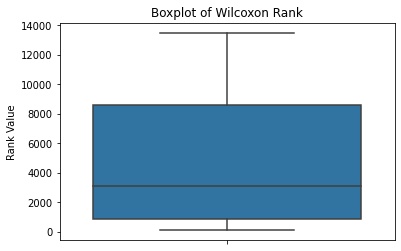

In [38]:
import seaborn as sns

sns.boxplot(y=baseline_rank)

# Add title and labels
plt.title("Boxplot of Wilcoxon Rank")
plt.ylabel("Rank Value")

# scGPT Embedding

In [39]:
from pathlib import Path

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
#import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [40]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="fibro", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model",
    model_name="best_model.pt",
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=15, # Default number of epochs for fine-tuning
    n_bins=51, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Currently logged in as: andrewhz-zhang. Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'fibro', 'do_train': True, 'load_model': '/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model', 'model_name': 'best_model.pt', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 15, 'n_bins': 51, 'lr': 0.0001, 'batch_size': 64, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [41]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

# n_hvg = 1200  # number of highly variable genes
max_seq_len = adata.n_vars + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

dataset_name = config.dataset_name
save_dir = Path(f"/scratch/ssd004/scratch/ahz/perturb/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")

save to /scratch/ssd004/scratch/ahz/perturb/dev_fibro-Apr01-21-35


In [42]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / config.model_name
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var.index
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    print(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

match 19219/19219 genes in vocabulary of size 60697.
Resume model from /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/best_model.pt, the model args will be overriden by the config /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/args.json.


In [43]:
torch.cuda.empty_cache()

In [44]:
# This step for binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Binning data ...


In [45]:
genes = adata.var.index.tolist()
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)
adata.obs['batch_id'] = adata.obs['condition'].copy()
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
input_layer_key = "X_binned"


ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=False,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (flag_encoder): Embedding(2, 512)
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
 

In [46]:
model.eval()
adata_t = adata.copy()

In [47]:
adata

AnnData object with n_obs × n_vars = 83476 × 19219
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage', 'gene_target', 'batch_id'
    var: 'id_in_vocab'
    uns: 'log1p', 'wilcoxon'
    obsm: 'bin_edges'
    layers: 'X_binned'

In [48]:
all_counts = (
    adata_t.layers[input_layer_key].A
    if issparse(adata_t.layers[input_layer_key])
    else adata_t.layers[input_layer_key]
)
celltypes_labels = adata_t.obs["cell_line"].tolist()
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata_t.obs["batch_id"].tolist()
batch_ids = np.array(batch_ids)

tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

In [49]:
gc.collect()

0

In [50]:
condition_ids = np.array(adata_t.obs["condition"].tolist())

# Initialize accumulators for running sums, counts, means, and the rank list
dict_sum_condition = {}
dict_count_condition = {}
dict_sum_condition_mean = {}
rank_list = []  # To store computed ranks from analysis iterations

sub_batch_size = 2048  # Use batch_size=16
num_samples = len(all_gene_ids)

# Create a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Process the dataset in random sub-batches
for i in tqdm(range(0, num_samples, sub_batch_size), desc="Random partitions"):
    # Get a batch of random indices
    batch_indices = random_indices[i : i + sub_batch_size]
    
    # Index the arrays using the random batch indices
    batch_gene_ids = all_gene_ids[batch_indices]
    batch_values = all_values[batch_indices].float()  # assuming all_values is a tensor
    batch_padding_mask = (src_key_padding_mask[batch_indices]
                          if src_key_padding_mask is not None else None)
    
    # Compute embeddings for the current random sub-batch
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
        gene_embeddings_batch = model.encode_batch(
            batch_gene_ids,
            batch_values,
            src_key_padding_mask=batch_padding_mask,
            batch_size=16,  # Explicitly use batch_size=16 here
            batch_labels=None,
            return_np=True,
        )
    
    # Update cumulative sums and counts, then recalc the running mean per condition
    # Note: We index condition_ids with the original index from batch_indices.
    for idx, sample_idx in enumerate(batch_indices):
        condition = condition_ids[sample_idx]
        if condition in dict_sum_condition:
            dict_sum_condition[condition] += gene_embeddings_batch[idx, :, :]
            dict_count_condition[condition] += 1
        else:
            dict_sum_condition[condition] = gene_embeddings_batch[idx, :, :]
            dict_count_condition[condition] = 1
        
        # Update the running mean for this condition
        dict_sum_condition_mean[condition] = dict_sum_condition[condition] / dict_count_condition[condition]
    
    # ----- Analysis for the batches processed so far -----
    # Map conditions to target genes via drug_target_map.
    dict_sum_target_gene_mean = {
        drug_target_map[drug]: dict_sum_condition_mean[drug]
        for drug in dict_sum_condition_mean.keys() if drug in drug_target_map
    }
    
    # (Optional) Get the gene vocabulary index from the first element
    gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
    
    # Create a list of perturbation targets, excluding control ('ctrl')
    perturb_targets = list(dict_sum_target_gene_mean.keys())
    if 'ctrl' in perturb_targets:
        perturb_targets.remove('ctrl')
    assert 'ctrl' not in perturb_targets
    
    # For each perturbation target, compute cosine distances and determine a ranking.
    if "ctrl" in dict_sum_target_gene_mean.keys():
        for t in perturb_targets:
            celltype_0 = t
            celltype_1 = 'ctrl'
            # Expand dims so that cosine_distances receives 2D arrays.
            gene_emb_celltype_0 = np.expand_dims(dict_sum_target_gene_mean[celltype_0][1:, :], axis=0)
            gene_emb_celltype_1 = np.expand_dims(dict_sum_target_gene_mean[celltype_1][1:, :], axis=0)
            gene_dist_dict = {}
            
            for j, g in tqdm(enumerate(genes), total=len(genes), desc=f"Analyzing {t}", disable=True):
                gene_dist = cosine_distances(gene_emb_celltype_0[:, j, :],
                                            gene_emb_celltype_1[:, j, :]).mean()
                gene_dist_dict[g] = gene_dist
            
            df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
            df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
            rank = np.where(df_deg.index == t)[0][0]
            print(f"Target {t} rank: {rank}")
            rank_list.append(rank)
        # ----- End Analysis -----
        
        # Save a box and whisker plot of rank_list as a PNG file.
        if rank_list:
            rank_mean = np.mean(rank_list)
            plt.figure()
            plt.boxplot(rank_list)
            # plt.title(f"Boxplot after {i + sub_batch_size} random samples processed (mean: {rank_mean:.2f})")
            plt.savefig(f"boxplot_{i + sub_batch_size}_samples_mean_{rank_mean:.2f}.png")
            plt.close()
    
    # Free memory used by the current sub-batch
    del gene_embeddings_batch
    gc.collect()

Random partitions:   0%|                                                                                                                                                                                                                                                     | 0/41 [03:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
dict_sum_target_gene_mean

{'TOP1': array([[-0.11615115,  0.24844779, -0.11260942, ...,  0.129785  ,
          0.16195199, -0.07603846],
        [-0.35701963,  0.24251509, -0.14003128, ...,  0.44481516,
         -0.31772625, -0.47711706],
        [-0.26342896, -0.05267463,  0.2484469 , ...,  0.36603752,
         -0.21433096, -0.8648994 ],
        ...,
        [-0.29426682,  0.27625751,  0.40686172, ..., -0.02277755,
          0.360824  , -0.42829806],
        [-0.1973518 , -0.01216858,  0.2917378 , ...,  0.15134878,
          0.11688229, -0.20826164],
        [-0.32079697, -0.3628924 , -0.03575832, ...,  0.36918753,
          0.27251163, -0.54093087]], dtype=float32)}

In [ ]:
# model.to(device)
# wandb.watch(model)

# with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
#     gene_embeddings = model.encode_batch(
#         all_gene_ids,
#         all_values.float(),
#         src_key_padding_mask=src_key_padding_mask,
#         batch_size=16,
#         batch_labels=None,
#         return_np=True,
#     )

MemoryError: Unable to allocate 4.19 TiB for an array with shape (83476, 26930, 512) and data type float32

In [ ]:
condition_ids

array(['AZD1390', 'AZD1390', 'AZD1390', ..., 'ctrl', 'ctrl', 'ctrl'],
      dtype='<U28')

In [ ]:
# dict_sum_condition = {}
# for i, c in enumerate(condition_ids):
#     if c in dict_sum_condition:
#         dict_sum_condition[c]+=gene_embeddings[i, :, :]
#     else:
#         dict_sum_condition[c]=gene_embeddings[i, :, :]

In [ ]:
dict_sum_condition

{'AZD1390': array([[ -8.148453 ,  18.083431 ,  -7.322385 , ...,   9.024526 ,
          13.199939 ,  -4.864532 ],
        [-26.262653 ,  17.475304 , -12.206568 , ...,  32.67421  ,
         -23.564209 , -35.327793 ],
        [-19.267513 ,  -4.245804 ,  18.698374 , ...,  24.58391  ,
         -16.135706 , -64.12608  ],
        ...,
        [-20.94814  ,  19.598473 ,  31.749445 , ...,  -2.0941536,
          30.456165 , -32.514927 ],
        [-13.197169 ,  -1.4194692,  23.054062 , ...,  11.142487 ,
           9.118238 , -16.487276 ],
        [-25.47564  , -19.530859 ,   6.156649 , ...,  22.46046  ,
          13.98754  , -33.78483  ]], dtype=float32),
 'Elimusertib hydrochloride': array([[ -7.5823164,  17.935604 ,  -6.8965144, ...,   8.540687 ,
          14.532765 ,  -6.2247953],
        [-26.128792 ,  17.725828 , -11.837996 , ...,  32.418293 ,
         -22.906015 , -36.569836 ],
        [-18.855818 ,  -4.047278 ,  19.72148  , ...,  24.393497 ,
         -14.55857  , -65.31503  ],
        ...,

In [ ]:
dict_sum_condition_mean = {}
groups = adata_t.obs.groupby('condition').groups
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition[i]/len(groups[i])

In [ ]:
dict_sum_target_gene_mean = {drug_target_map[drug] : dict_sum_condition_mean[drug] for drug in dict_sum_condition_mean.keys()}
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
perturb_targets = list(dict_sum_target_gene_mean.keys())
perturb_targets.remove('ctrl')
assert 'ctrl' not in perturb_targets
rank_list = []

for t in perturb_targets:
    celltype_0 = t
    celltype_1 = 'ctrl'
    gene_emb_celltype_0 = np.expand_dims(dict_sum_target_gene_mean[celltype_0][1:, :], 0)
    gene_emb_celltype_1 = np.expand_dims(dict_sum_target_gene_mean[celltype_1][1:, :], 0)
    gene_dist_dict = {}
    for i, g in tqdm(enumerate(genes)):
        gene_dist_dict[g] = cosine_distances(gene_emb_celltype_0[:, i, :], gene_emb_celltype_1[:, i, :]).mean()
    df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
    df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
    print(t, np.where(df_deg.index==t)[0][0])
    rank_list.append(np.where(df_deg.index==t)[0][0])

In [ ]:
def is_one_to_one_mapping(d):
    """
    Checks if a dictionary represents a one-to-one mapping.
    Returns True if it is, otherwise returns False and a dictionary
    of colliding values with their associated keys.
    """
    value_to_keys = {}
    collisions = {}
    
    for key, value in d.items():
        if value in value_to_keys:
            value_to_keys[value].append(key)
            collisions[value] = value_to_keys[value]
        else:
            value_to_keys[value] = [key]
    
    if collisions:
        return False, collisions
    return True, None

In [ ]:
is_one_to_one_mapping(drug_target_map)

(False,
 {'PSMB5': ['Bortezomib', 'Ixazomib'],
  'PRKAA1': ['EX229', 'MK-3903'],
  'MTOR': ['AZD-8055', 'Sapanisertib']})

## Save Results & Analysis

In [ ]:
adata.uns['wilcoxon']['names']

rec.array([('TIPARP', 'SF3B2', 'RPS19', 'NPM1', 'RPS8', 'CRIM1', 'MET', 'FTL', 'MTATP6P1', 'MT-RNR2', 'RPS19', 'TFPI2', 'FTH1', 'PLEC', 'EEF1G', 'RPS19', 'MT-ATP6', 'RPL37A', 'MYO1B', 'RPL37A', 'RPS19', 'RPL19', 'CRIM1', 'RPL37A', 'RPS19', 'RACK1', 'RPS19', 'TIPARP', 'RPS19', 'MT-ATP8', 'TALAM1'),
           ('RACK1', 'HNRNPH1', 'MT-ATP8', 'PRRC2C', 'EEF2', 'LINC-PINT', 'TFPI', 'RPL37A', 'RPS3', 'RPL4', 'RPS12', 'EFR3A', 'PDCD5', 'MYH9', 'MT-ND4', 'RPS3', 'RPL18', 'RPLP2', 'DGKD', 'RPS8', 'RPS3', 'RPL12', 'PLOD2', 'RPL26', 'MT-ATP8', 'NPM1', 'MT2A', 'TALAM1', 'RPS8', 'RPS19', 'ARHGAP26'),
           ('ACTG1', 'KRT18', 'MT2A', 'PPP2R5E', 'PRRC2C', 'SHB', 'LINC-PINT', 'RACK1', 'HNRNPH1', 'CLU', 'RPL37A', 'MT-ATP8', 'CRIM1', 'PABPC1', 'MBNL2', 'MT-ND4', 'EEF2', 'RPS19', 'MBNL2', 'RPLP2', 'TMSB10', 'RPS19', 'FAM107B', 'RPS3', 'RPS3', 'EIF4A1', 'MT-ATP8', 'TPI1', 'RPL11', 'RPS3', 'PSD3'),
           ...,
           ('PDE4D', 'AADACP1', 'EFNA5', 'MT-RNR2', 'MCL1', 'NCOR2', 'PFN1', 'TAOK1', '

In [ ]:
perturb_targets

['EIF4E',
 'GSK3B',
 'ATM',
 'PRKDC',
 'MTOR',
 'PIK3CA',
 'CYP19A1',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'MAPK7',
 'PRKAA1',
 'ATR',
 'PBK',
 'TOP1',
 'RPS6KB1',
 'KLF5',
 'NR3C1',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [ ]:
# rerun wilcoxon rank for gene targets instead

baseline_rank_t = []

for t in perturb_targets:
    # print(c)
    hvg_list = adata.uns['wilcoxon']['names'][t]
    p_val = adata.uns['wilcoxon']['pvals_adj'][t]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(t, np.where(df_gene_emb_dist.gene.values==t)[0][0])
    baseline_rank_t.append(np.where(df_gene_emb_dist.gene.values==t)[0][0])

EIF4E 30340
GSK3B 214
ATM 13787
PRKDC 13057
MTOR 26540
PIK3CA 26058
CYP19A1 33527
EPAS1 29464
PSMB5 27511
MET 28530
PTGS2 182
MAPK7 19449
PRKAA1 11610
ATR 18390
PBK 26045
TOP1 28154
RPS6KB1 27795
KLF5 13737
NR3C1 13462
EPHB4 12028
MAP3K8 18611
MAP4K4 13821
MAPK14 28524
RET 35699
KRAS 27906
SMO 12779
MAP2K1 27464
AURKB 30528
ERBB2 19029
BRAF 31170
BCL2 32362


In [ ]:
baseline_rank_t

[30340,
 214,
 13787,
 13057,
 26540,
 26058,
 33527,
 29464,
 27511,
 28530,
 182,
 19449,
 11610,
 18390,
 26045,
 28154,
 27795,
 13737,
 13462,
 12028,
 18611,
 13821,
 28524,
 35699,
 27906,
 12779,
 27464,
 30528,
 19029,
 31170,
 32362]

In [ ]:
perturb_targets

['EIF4E',
 'GSK3B',
 'ATM',
 'PRKDC',
 'MTOR',
 'PIK3CA',
 'CYP19A1',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'MAPK7',
 'PRKAA1',
 'ATR',
 'PBK',
 'TOP1',
 'RPS6KB1',
 'KLF5',
 'NR3C1',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [ ]:
len(perturb_targets)

31

In [ ]:
len(baseline_rank_t)

31

In [ ]:
len(rank_list)

31

In [ ]:
df_results = df = pd.DataFrame({
    'conditions': perturb_targets,
    'wilcoxon': baseline_rank_t,
    'scGPT_rank': rank_list
})

In [ ]:
df_results

,conditions,wilcoxon,scGPT_rank
0,EIF4E,30340,17175
1,GSK3B,214,311
2,ATM,13787,462
3,PRKDC,13057,18819
4,MTOR,26540,1189
5,PIK3CA,26058,4624
6,CYP19A1,33527,3903
7,EPAS1,29464,2785
8,PSMB5,27511,26759
9,MET,28530,864


In [ ]:
df_results.mean()

wilcoxon      21863.645161
scGPT_rank     8328.806452
dtype: float64

In [ ]:
df_results.to_csv('/scratch/ssd004/scratch/ahz/perturb/vevo_tahoe_ranks_Mar13.csv')

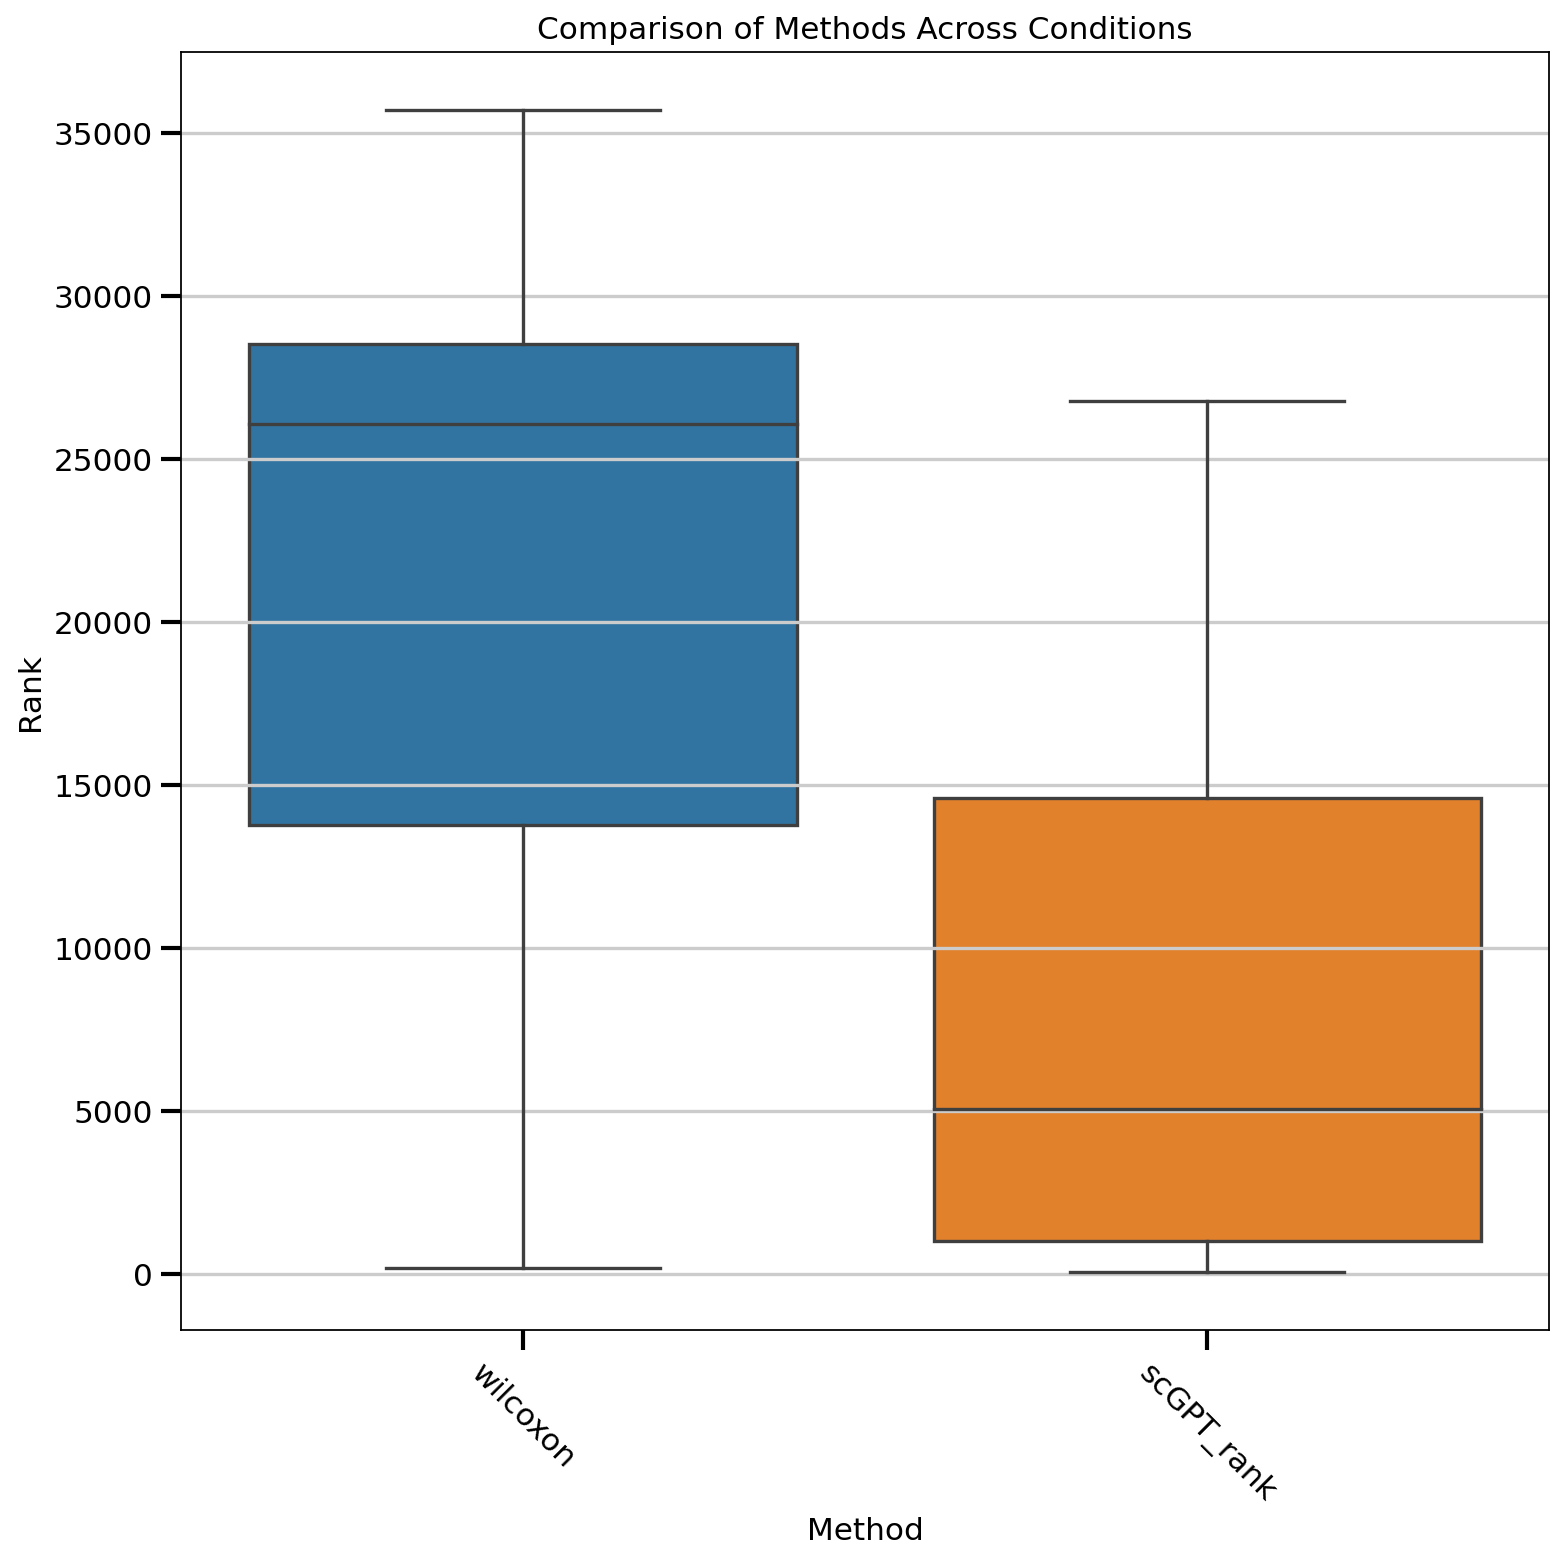

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_results)

# Add titles and labels
plt.title('Comparison of Methods Across Conditions')
plt.xlabel('Method')
plt.ylabel('Rank')
plt.xticks(rotation=-45)
# plt.yscale('log')
# Display the plot
plt.tight_layout()

plt.legend([],[], frameon=False)

<AxesSubplot:xlabel='wilcoxon', ylabel='scGPT_rank'>

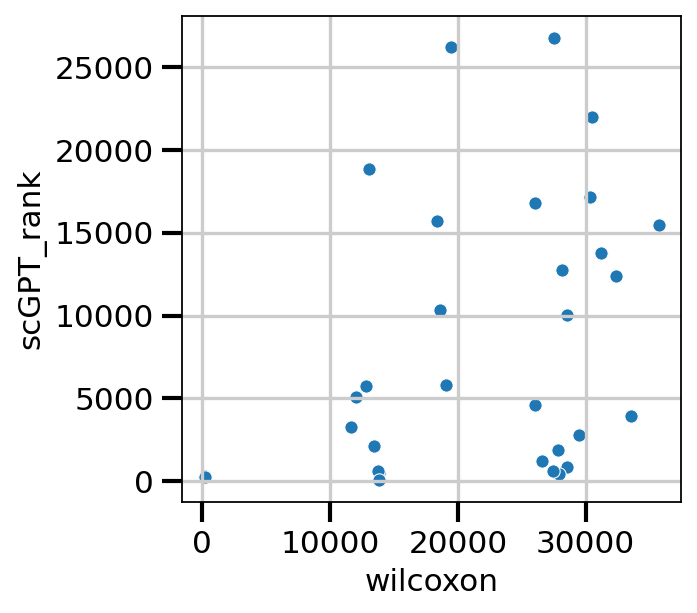

In [ ]:
sns.scatterplot(data=df_results, x="wilcoxon", y="scGPT_rank")

In [ ]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_results['wilcoxon'], df_results['scGPT_rank'])

print(f'Pearson Correlation: {corr}, p-value: {p_value}')

Pearson Correlation: 0.3373957721744743, p-value: 0.06342606451828253
